In [22]:
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
import csv
import pandas as pd
from astropy import modeling
from scipy import optimize
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.integrate import quad
import datetime
from datetime import timedelta
from datetime import datetime

Import Thomson data

In [23]:
filename="Thomson_2021-06-10_#28924.txt"
df = pd.read_csv(filename, delimiter = "\t", skiprows=5, warn_bad_lines=True, error_bad_lines=False) #remove lines that do not have 5 columns 
data_columns=df.columns.values
num_df = (df.drop(data_columns, axis=1).join(df[data_columns].apply(pd.to_numeric, errors='coerce'))) #remove the lines that are not fully numerical
num_df = num_df[num_df[data_columns].notnull().all(axis=1)] #remove the lines that are not fully numerical
num_df.index=list(range(0, len(num_df))) #sets the indec to start at 0 and increase by 1, row number

There are 3 Thomson measurements per exp so we need to see which times correspond to thebegining and end of each exp. 

In [24]:
difference = num_df.diff(axis=0) #difference between two consecutive rows
t12=num_df[difference.iloc[:,0]<0].index.values #the 1st column is the position which per measurement always increases, so if the diff is negative it means we have a new measurement 
T1=num_df.iloc[0:t12[0]]
T2=num_df.iloc[t12[0]:t12[1]]
T3=num_df.iloc[t12[1]:len(num_df)]

In [25]:
def gaussian(x, amplitude, mean, stddev,offset): #make a funciton that returns a gaussian
    return amplitude * np.exp(-((x - mean)/ stddev)**2/ 2)+offset

In [26]:
popt, pcov = optimize.curve_fit(gaussian, T1.iloc[:,0], T1.iloc[:,2]) # popt is: [amplitude, mean, stddev,offset]
x=np.arange(-15,15,0.1)

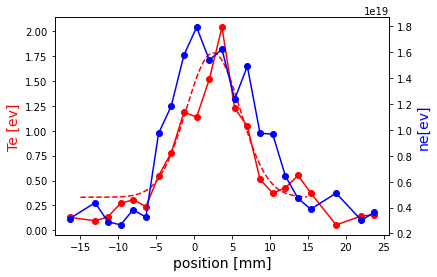

In [27]:
fig,ax = plt.subplots()
ax.plot(T3.iloc[:,0],T3.iloc[:,2],color="red",marker="o") 
plt.ylabel('Te [ev]', color="red",fontsize=14)
plt.xlabel('position [mm]', fontsize=14)
ax2=ax.twinx()
ax.plot( x, gaussian(x, *popt),"--",color='red')
ax2.plot(T3.iloc[:,0],T3.iloc[:,1],color="blue",marker="o")
ax2.set_ylabel("ne[ev]",color="blue",fontsize=14)
plt.show()

In [28]:
cp=4200
E=97320

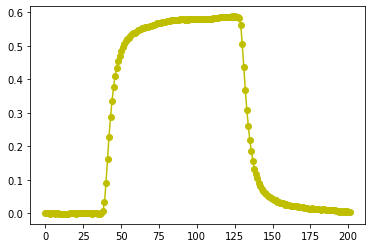

In [33]:
data=pd.read_csv("temp.csv", delimiter='|', skiprows=1)   #Import the experimental data
data["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in data["Date/Time"]] # converts the time strings to readable datetime
time_int=data["Date/Time"]-data["Date/Time"][0]
time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
data = data.assign(t=time_int2) # assign the interval found in seconds as a column
data.Value=data.Value-data.Value.iloc[0:37].mean()
fig,ax = plt.subplots()
ax.plot(data.t,data.Value, 'yo-' ,label='$B=1.6T,I=200A$ IR')
Tint=np.trapz(data.Value,data.t)
#data[data.t == 37].index[0]


In [34]:
mflow=E/(Tint*cp) #[kg/s]


574.5421854489308

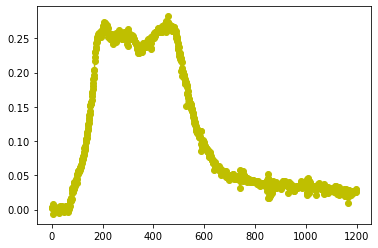

In [37]:
data=pd.read_csv("calorimetry.csv", delimiter='|', skiprows=1)   #Import the experimental data
data["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in data["Date/Time"]] # converts the time strings to readable datetime
tstart=["2021-06-10 11:21","2021-06-10 11:44","2021-06-10 13:50","2021-06-10 14:12","2021-06-10 14:38","2021-06-10 14:53","2021-06-10 15:07"]
tstart = [datetime.strptime(x,'%Y-%m-%d %H:%M') for x in tstart] # converts the time strings to readable datetime
tend=[tstart[x]+timedelta(seconds=20*60) for x in range(len(tstart))]
ind1=data[data["Date/Time"]>tstart[0]].index[0]
ind2=data[data["Date/Time"]<tend[0]].index[-1]
tint=data["Date/Time"].iloc[ind1:ind2]
offset=data.Value.iloc[ind1-100:ind1].mean()
column_names = ["time", "temp"]
expi = pd.DataFrame(columns = column_names)
expi=expi.assign(time=data["Date/Time"].iloc[ind1:ind2])
expi=expi.assign(temp=data.Value.iloc[ind1:ind2]-offset)
time_int=expi.time-expi.time.iloc[0]
time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
expi = expi.assign(t=time_int2) # assign the interval found in seconds as a column
fig,ax = plt.subplots()
ax.plot(expi.t,expi.temp, 'yo-' ,label='$B=1.6T,I=200A$ IR')
Tint=np.trapz(expi.temp,expi.t)

#grid(b=True, which='major', color='#666666')
#minorticks_on()
#grid(b=True, which='minor', color='#999999', alpha=0.2)
E=mflow*(Tint*cp) #[J]
P=E/420  # [W]divided by 7 min
P

Text(0.5, 0, 'position [mm]')

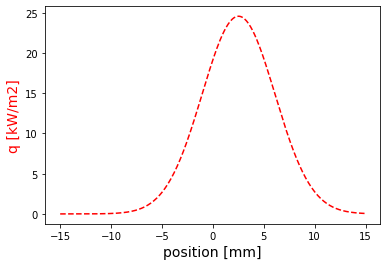

In [38]:
def integrand(x, mean, stddev,offset):
    return np.exp(-((x - mean)/ stddev)**2/ 2)+offset

I = quad(integrand, -0.015, 0.015, args=(popt[1], popt[2], 0)) #assume offset is zero, there is no heat flux on the edges
A=P/I[0]
A
fig,ax = plt.subplots()
ax.plot( x, gaussian(x, A,popt[1], popt[2], 0)/1e3,"--",color='red')
popt[1:]
plt.ylabel('q [kW/m2]', color="red",fontsize=14)
plt.xlabel('position [mm]', fontsize=14)